In [1]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
import open3d as o3d 
from projections import camera_to_image, world_to_camera, filter_pixel_points
from utils import get_cameras, get_extrinsic_matrix, get_intrinsic_matrix 
from utils import save_ply

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Read the point cloud
gaussian_file = './point_cloud/iteration_30000/point_cloud.ply' 

In [3]:
pcd = o3d.io.read_point_cloud(gaussian_file)

In [4]:
pcd_array = np.asarray(pcd.points)
pcd_array = torch.from_numpy(pcd_array)
print(pcd_array)

tensor([[ -0.1773,   1.4565,  -0.6173],
        [ -0.2395,  -0.2551,   1.3519],
        [ -0.5875,  -0.3807,  -0.1670],
        ...,
        [ 14.6480,  -0.6251, -26.5749],
        [  0.2383,  -8.9183,  24.5446],
        [-34.5657,  -8.3790,   3.8361]], dtype=torch.float64)


In [5]:
# save_ply(pcd_array) 

### Converting World Coordinates to Pixel Coordinates

In [14]:
# Get Cameras 

cameras = get_cameras('cameras.json')  
i = 15
print('Image Name: ', cameras[i]['img_name'])

# WIDTH = cameras[i]['width'] 
# HEIGHT = cameras[i]['height'] 

WIDTH = cameras[i]['width'] 
HEIGHT = cameras[i]['height']

# Get Extrinsic & intrinsic Matrices for first camera 
extrinsic = get_extrinsic_matrix(cameras[i])  
intrinsic = get_intrinsic_matrix(cameras[i]) 

Image Name:  000009


In [15]:
# Convert to Camera Coordinates 
camera_coords = world_to_camera(pcd_array, extrinsic) 
print(camera_coords) 

tensor([[ -3.1418,  -2.1784,  -3.2259,  ...,  -2.9801,   9.9039, -30.5852],
        [  0.7374,  -0.8054,  -1.0502,  ...,  -3.6923,  -7.5390,  -8.1832],
        [  1.9503,   3.8219,   2.6876,  ..., -27.6853,  24.3610,  23.5469]],
       dtype=torch.float64)


In [16]:
# Convert Camera Coordinates to Pixel Coordinates 
pixel_coords, points_depths = camera_to_image(camera_coords, intrinsic) 
print(pixel_coords) 

tensor([[ -895,   315,  -417,  ..., -2429,  1451,  -532],
        [  982,   301,    93,  ...,   163,   187,   143]], dtype=torch.int32)


In [17]:
# Filter points outside the image width and height  

filt_points, filt_indices = filter_pixel_points(pixel_coords, WIDTH, HEIGHT) 

print(filt_indices)
print(filt_points) 

tensor([False,  True, False,  ..., False,  True, False])
tensor([      1,       5,       8,  ..., 1796930, 1796934, 1796937])
tensor([[ 315, 1404,  990,  ...,  331,  202, 1451],
        [ 301,  899,  472,  ...,  417,  263,  187]], dtype=torch.int32)


In [18]:
filt_points.t()

tensor([[ 315,  301],
        [1404,  899],
        [ 990,  472],
        ...,
        [ 331,  417],
        [ 202,  263],
        [1451,  187]], dtype=torch.int32)

In [19]:
img = torch.zeros((HEIGHT, WIDTH))  

x = filt_points.t()[:, 0].squeeze() 
y = filt_points.t()[:, 1].squeeze()   

img[y, x] = 1
print(img)

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [20]:
from PIL import Image 

im = Image.fromarray((img.numpy()*255).astype(np.uint8), 'L')

name = 'output.png'
im.save(name) 

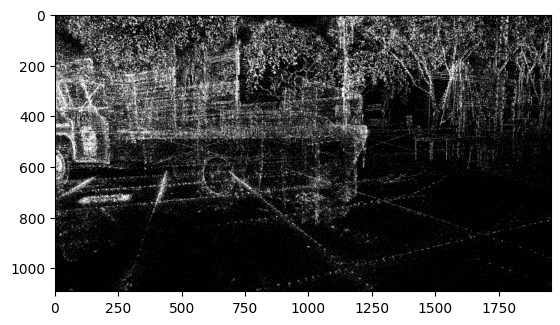

In [21]:
# Visualize grayscale projected view 

import matplotlib.pyplot as plt 

# We get inverted projection, so I will rotate 

# img = np.rot90(img.numpy(), 2) 
# img = torch.fliplr(img) 

plt.imshow(img, cmap='gray') 
plt.show()